Raw shape: (82, 15)
Columns: ['Timestamp', "You're Currently On", 'Gender', 'Age', 'Current CGPA', 'How many hours do you spend on studying per week?', 'How many credits are you currently enrolled in?', 'Do you participate in extracurricular activities?', 'If yes, how many hours per week?', 'Do you have a part-time job? (Including Tuition)', 'If yes, how many hours per week?.1', 'How would you rate your stress level this semester?', 'How would you rate your anxiety level?', 'How many hours of sleep do you get per night?(On Average)', 'How would you rate your overall sleep quality?']
Auto-mapped columns: {'Timestamp': 'timestamp', 'Gender': 'gender', 'Age': 'age', 'Current CGPA': 'cgpa', 'How many hours do you spend on studying per week?': 'study_hours_per_week', 'Do you participate in extracurricular activities?': 'extracurricular', 'Do you have a part-time job? (Including Tuition)': 'job', 'How would you rate your stress level this semester?': 'stress_1to5', 'How would you rate your a

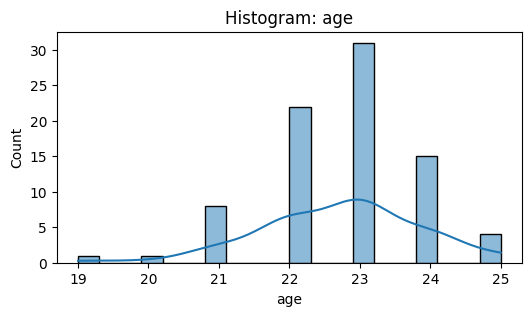

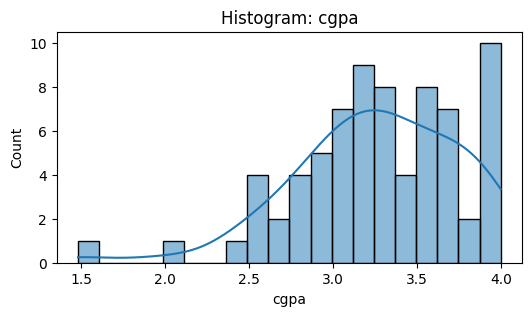

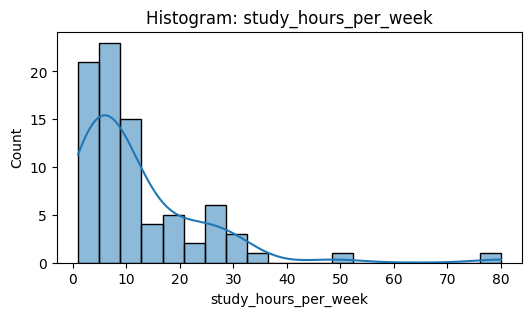

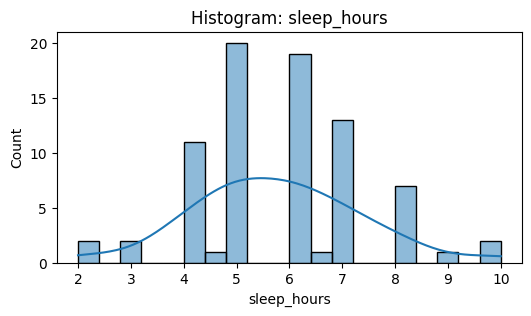

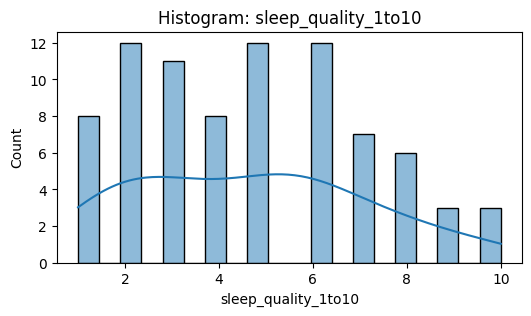

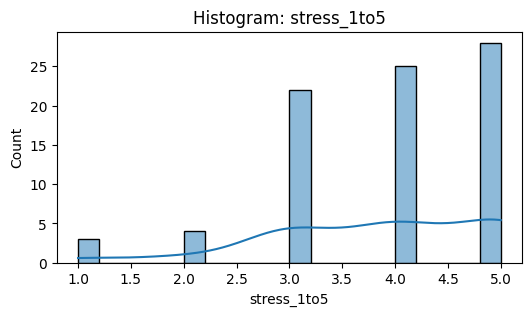

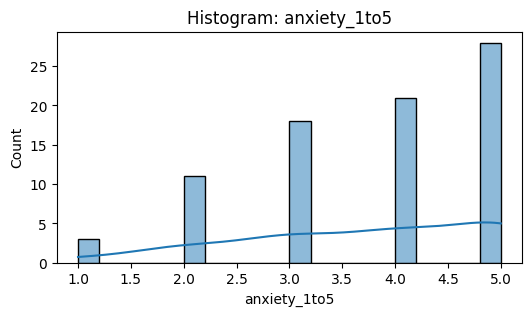

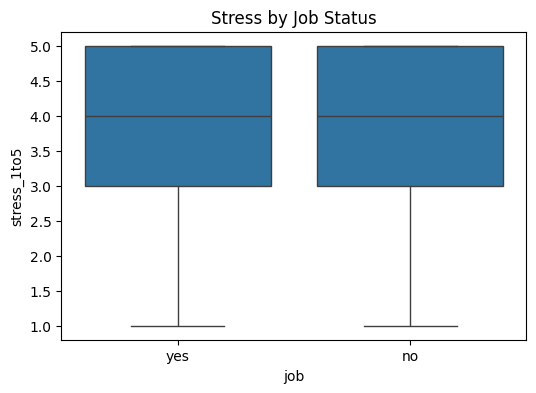

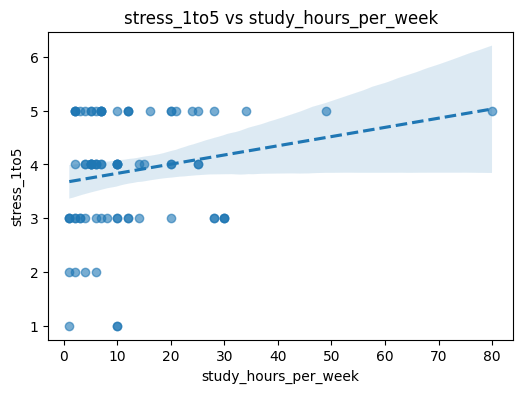

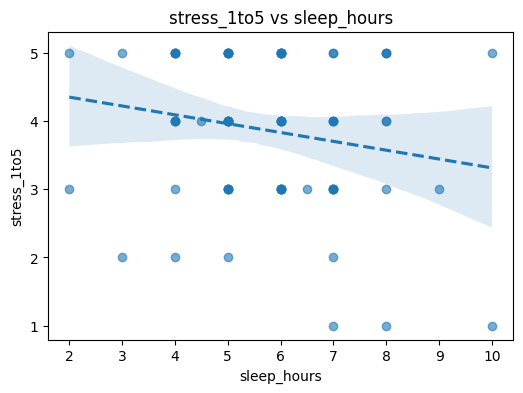

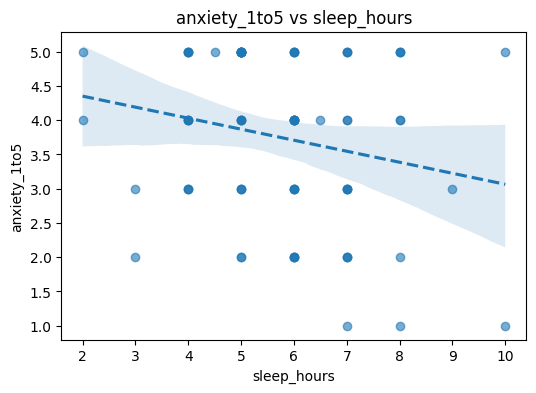

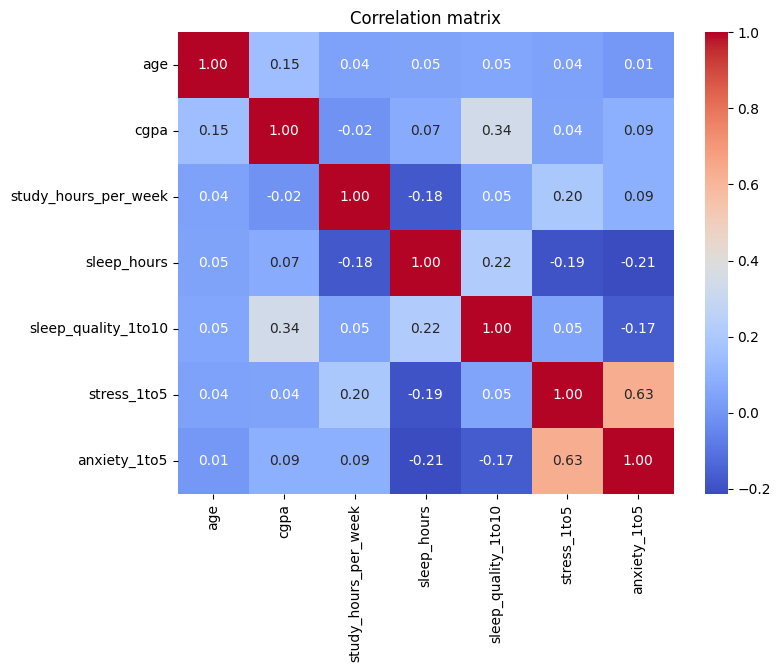


--- Hypothesis tests (alpha = 0.05) ---

Test: Stress by Job Status
H0: mean(stress | job=Yes) == mean(stress | job=No)
H1: they differ
Levene p (equal variances): 0.21596794675279526
t = 0.521 p = 0.6038
Cohen's d: 0.117
Result: Fail to reject H0 -> no evidence of difference
Shapiro p-values (Yes,No): 1.403518559472662e-05 0.0003882584787481778
Normality suspicious: running Mann-Whitney U as nonparametric alternative.
Mann-Whitney U p = 0.6517360602239471

Test: Correlation study_hours_per_week vs stress_1to5
Pearson r = 0.197 p = 0.076
Spearman rho = 0.186 p = 0.0946

Test: Proportion of high_stress by job status
z = 0.816 p = 0.4147

Simple regression: stress ~ study_hours_per_week
                            OLS Regression Results                            
Dep. Variable:            stress_1to5   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                

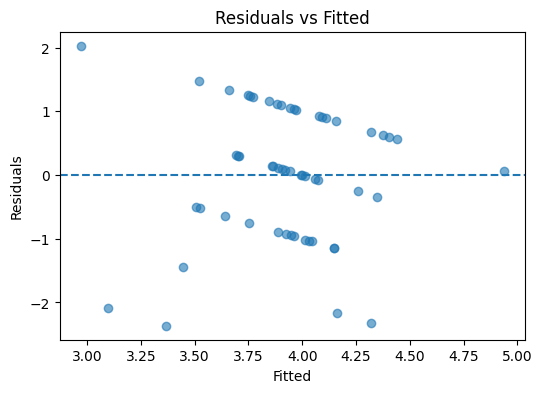

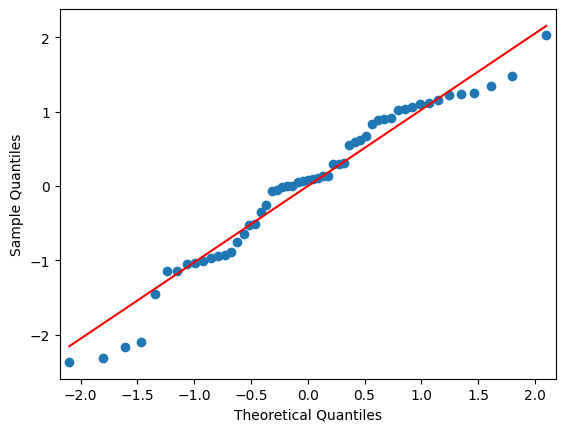

Breusch-Pagan LM p: 0.07115739065307328 F p: 0.06915658995144347

VIFs:
            variable       VIF
               const 19.074118
study_hours_per_week  1.047148
         sleep_hours  1.099188
 sleep_quality_1to10  1.085483
 extracurricular_bin  1.024043

Test metrics: RMSE = 1.039, R2 = -0.037
CV R2 mean = -0.140 (std 0.197)

All done. Cleaned CSV saved to: /content/data/cleaned_survey_data.csv


In [5]:
# cse303_colab_full.py
"""
CSE303 — Project script (Colab-friendly)
- Download CSV from Google Drive (shareable link) or read local file
- Clean and standardize survey data
- Run EDA: summary, histograms, boxplots, correlation
- Run hypothesis tests with H0/H1, alpha, assumptions, effect sizes, alternatives
- Fit simple and multiple regressions with diagnostics, train/test evaluation, CV, robust SEs
- Save cleaned CSV to /content/data/cleaned_survey_data.csv
"""

import os
import re
import sys
import subprocess
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# ---------------- CONFIG ----------------
GOOGLE_DRIVE_LINK = "https://drive.google.com/file/d/1KLnVKougQauelIE9_83vr9uiZreArfoJ/view?usp=drive_link"
OUTPUT_FILENAME = "survey_responses.csv"
DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
CSV_LOCAL_PATH = DATA_DIR / OUTPUT_FILENAME
CLEANED_PATH = DATA_DIR / "cleaned_survey_data.csv"

# ---------------- Utilities ----------------
def extract_drive_id(url: str):
    if not isinstance(url, str) or url.strip() == "":
        return None
    m = re.search(r"/d/([^/]+)", url)
    if m:
        return m.group(1)
    m = re.search(r"[?&]id=([^&]+)", url)
    if m:
        return m.group(1)
    return None

def ensure_gdown_installed():
    try:
        import gdown  # noqa: F401
    except Exception:
        print("Installing gdown...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "gdown"], check=True)

def download_from_drive(file_id: str, out_path: Path):
    ensure_gdown_installed()
    import gdown
    url = f"https://drive.google.com/uc?id={file_id}"
    print("Downloading from:", url)
    gdown.download(url, str(out_path), quiet=False)
    if not out_path.exists():
        raise FileNotFoundError("Download failed. Make sure file is shared 'Anyone with the link'.")
    return out_path

def safe_read_csv(path: Path):
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, encoding="latin1", low_memory=False)

# ---------------- Cleaning ----------------
def clean_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    rename_map = {}
    for col in df.columns:
        low = col.lower().strip()
        if 'year' in low and 'study' in low:
            rename_map[col] = 'year_of_study'
        elif low.startswith('gender'):
            rename_map[col] = 'gender'
        elif low == 'age' or ('age' in low and 'your' in low):
            rename_map[col] = 'age'
        elif 'cgpa' in low:
            rename_map[col] = 'cgpa'
        elif 'study' in low and ('week' in low or 'per' in low):
            rename_map[col] = 'study_hours_per_week'
        elif 'course' in low and any(k in low for k in ('enroll','credit','courses','course')):
            rename_map[col] = 'courses_enrolled'
        elif 'extracurricular' in low or ('extra' in low and 'activity' in low):
            if 'hour' in low or 'per' in low:
                rename_map[col] = 'extra_hours_per_week'
            else:
                rename_map[col] = 'extracurricular'
        elif 'job' in low and 'hour' in low:
            rename_map[col] = 'job_hours_per_week'
        elif 'job' in low:
            rename_map[col] = 'job'
        elif 'stress' in low:
            rename_map[col] = 'stress_1to5'
        elif 'anxiety' in low:
            rename_map[col] = 'anxiety_1to5'
        elif 'sleep' in low and 'quality' in low:
            rename_map[col] = 'sleep_quality_1to10'
        elif 'sleep' in low and 'hour' in low:
            rename_map[col] = 'sleep_hours'
        elif 'timestamp' in low or low == 'time':
            rename_map[col] = 'timestamp'
    if rename_map:
        print("Auto-mapped columns:", rename_map)
    df = df.rename(columns=rename_map)

    # Trim strings
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].astype(str).str.strip()

    # Numeric coercion (robust)
    def to_numeric_col(s):
        try:
            return pd.to_numeric(s, errors='coerce')
        except Exception:
            return s.astype(str).str.replace(',', '').str.extract(r'([-+]?\d*\.?\d+)')[0].astype(float)

    numeric_cols = ['age','cgpa','study_hours_per_week','courses_enrolled','extra_hours_per_week',
                    'job_hours_per_week','sleep_hours','sleep_quality_1to10','stress_1to5','anxiety_1to5']
    for c in numeric_cols:
        if c in df.columns:
            df[c] = to_numeric_col(df[c])

    # Normalize yes/no
    def norm_yesno(series):
        s = series.astype(str).str.strip().str.lower().replace({'nan': None})
        s = s.replace({'yes.':'yes','yes':'yes','y':'yes','true':'yes','1':'yes',
                       'no.':'no','no':'no','n':'no','false':'no','0':'no'})
        return s

    if 'extracurricular' in df.columns:
        df['extracurricular'] = norm_yesno(df['extracurricular'])
        df['extracurricular_bin'] = (df['extracurricular'] == 'yes').astype(int)
    else:
        if 'extra_hours_per_week' in df.columns:
            df['extracurricular_bin'] = (df['extra_hours_per_week'].fillna(0) > 0).astype(int)

    if 'job' in df.columns:
        df['job'] = norm_yesno(df['job'])
        df['job_bin'] = (df['job'] == 'yes').astype(int)
    else:
        if 'job_hours_per_week' in df.columns:
            df['job_bin'] = (df['job_hours_per_week'].fillna(0) > 0).astype(int)

    if 'job' in df.columns and 'job_hours_per_week' in df.columns:
        df.loc[df['job']=='no', 'job_hours_per_week'] = df.loc[df['job']=='no', 'job_hours_per_week'].fillna(0)
    if 'extracurricular' in df.columns and 'extra_hours_per_week' in df.columns:
        df.loc[df['extracurricular']=='no', 'extra_hours_per_week'] = df.loc[df['extracurricular']=='no', 'extra_hours_per_week'].fillna(0)

    if 'year_of_study' in df.columns:
        df['year_of_study'] = pd.to_numeric(df['year_of_study'], errors='coerce').astype('Int64')

    if 'stress_1to5' in df.columns:
        df['high_stress'] = (df['stress_1to5'] >= 4).astype(int)

    df = df.loc[:, df.notna().any()]
    df = df.reset_index(drop=True)
    return df

# ---------------- EDA & Tests ----------------
def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    sa, sb = np.std(a, ddof=1), np.std(b, ddof=1)
    s_pool = np.sqrt(((na-1)*sa*sa + (nb-1)*sb*sb) / (na+nb-2)) if (na+nb-2)>0 else np.nan
    return (a.mean() - b.mean()) / s_pool if s_pool != 0 else np.nan

def eta_squared(groups, overall_series):
    ss_between = sum([len(g) * (g.mean() - overall_series.mean())**2 for g in groups])
    ss_total = ((overall_series - overall_series.mean())**2).sum()
    return ss_between / ss_total if ss_total > 0 else np.nan

def run_tests_and_print(df):
    alpha = 0.05
    print("\n--- Hypothesis tests (alpha = 0.05) ---")
    # 1) Stress by job
    if {'job','stress_1to5'}.issubset(df.columns):
        print("\nTest: Stress by Job Status")
        print("H0: mean(stress | job=Yes) == mean(stress | job=No)")
        print("H1: they differ")
        grp_yes = df.loc[df['job']=='yes','stress_1to5'].dropna()
        grp_no = df.loc[df['job']=='no','stress_1to5'].dropna()
        if len(grp_yes)>1 and len(grp_no)>1:
            lev_p = stats.levene(grp_yes, grp_no).pvalue
            print("Levene p (equal variances):", lev_p)
            t_stat, p = stats.ttest_ind(grp_yes, grp_no, equal_var=False)
            print("t =", round(t_stat,3), "p =", round(p,4))
            print("Cohen's d:", round(cohens_d(grp_yes, grp_no),3))
            if p < alpha:
                print("Result: Reject H0 -> groups differ")
            else:
                print("Result: Fail to reject H0 -> no evidence of difference")
            # normality check
            if len(grp_yes) <= 5000:
                p_sh_y = stats.shapiro(grp_yes).pvalue if len(grp_yes)>=3 else None
                p_sh_n = stats.shapiro(grp_no).pvalue if len(grp_no)>=3 else None
                print("Shapiro p-values (Yes,No):", p_sh_y, p_sh_n)
                if (p_sh_y is not None and p_sh_y < alpha) or (p_sh_n is not None and p_sh_n < alpha):
                    print("Normality suspicious: running Mann-Whitney U as nonparametric alternative.")
                    mw = stats.mannwhitneyu(grp_yes, grp_no, alternative='two-sided')
                    print("Mann-Whitney U p =", mw.pvalue)
        else:
            print("Insufficient data for t-test.")

    # 2) ANOVA: anxiety across years
    if {'year_of_study','anxiety_1to5'}.issubset(df.columns):
        print("\nTest: Anxiety across year_of_study")
        print("H0: all year means equal; H1: at least one differs")
        groups = [df.loc[df['year_of_study']==k,'anxiety_1to5'].dropna() for k in sorted(df['year_of_study'].dropna().unique())]
        groups = [g for g in groups if len(g)>1]
        if len(groups) >= 2:
            lev_p = stats.levene(*groups).pvalue
            print("Levene p:", lev_p)
            F, p = stats.f_oneway(*groups)
            print("F =", round(F,3), "p =", round(p,4))
            print("eta-squared:", round(eta_squared(groups, df['anxiety_1to5']),3))
            if p < alpha:
                print("Reject H0 -> at least one mean differs")
            else:
                print("Fail to reject H0 -> no evidence of difference")
        else:
            print("Insufficient group sizes for ANOVA.")

    # 3) Correlation: study_hours vs stress
    if {'study_hours_per_week','stress_1to5'}.issubset(df.columns):
        print("\nTest: Correlation study_hours_per_week vs stress_1to5")
        v = df[['study_hours_per_week','stress_1to5']].dropna()
        if len(v) >= 3:
            r, p = stats.pearsonr(v['study_hours_per_week'], v['stress_1to5'])
            sr, sp = stats.spearmanr(v['study_hours_per_week'], v['stress_1to5'])
            print("Pearson r =", round(r,3), "p =", round(p,4))
            print("Spearman rho =", round(sr,3), "p =", round(sp,4))
        else:
            print("Insufficient observations for correlation test.")

    # 4) Proportion test: high_stress by job
    if {'job','high_stress'}.issubset(df.columns):
        print("\nTest: Proportion of high_stress by job status")
        grp1 = df.loc[df['job']=='yes','high_stress'].dropna().astype(int)
        grp2 = df.loc[df['job']=='no','high_stress'].dropna().astype(int)
        if len(grp1)>0 and len(grp2)>0:
            from statsmodels.stats.proportion import proportions_ztest
            count = np.array([grp1.sum(), grp2.sum()])
            nobs = np.array([len(grp1), len(grp2)])
            z, p = proportions_ztest(count, nobs)
            print("z =", round(z,3), "p =", round(p,4))
        else:
            print("Insufficient data for proportion test.")

# ---------------- Modeling ----------------
def compute_vif_df(X_df: pd.DataFrame):
    Xc = sm.add_constant(X_df.fillna(0))
    vif_list = [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
    return pd.DataFrame({'variable': Xc.columns, 'VIF': vif_list})

def fit_models_with_eval(df, target, predictors):
    df2 = df[[target] + predictors].dropna()
    if df2.shape[0] < (len(predictors) + 3):
        raise ValueError("Not enough rows for regression with these predictors.")
    X = df2[predictors]
    y = df2[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_df = pd.concat([y_train, X_train], axis=1)
    formula = f"{target} ~ " + " + ".join(predictors)
    model = smf.ols(formula=formula, data=train_df).fit()
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    # CV with sklearn
    lr = LinearRegression()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(lr, X, y, scoring='r2', cv=cv)
    robust = model.get_robustcov_results(cov_type='HC3')
    return {
        'model': model, 'robust': robust,
        'test_rmse': rmse, 'test_r2': r2,
        'cv_r2_mean': float(np.nanmean(cv_scores)), 'cv_r2_std': float(np.nanstd(cv_scores))
    }

# ---------------- Main ----------------
def main():
    # If CSV missing, optionally ask user to upload manually in Colab. Here we attempt Drive download.
    drive_id = extract_drive_id(GOOGLE_DRIVE_LINK)
    if drive_id and not CSV_LOCAL_PATH.exists():
        download_from_drive(drive_id, CSV_LOCAL_PATH)
    if not CSV_LOCAL_PATH.exists():
        raise FileNotFoundError(f"CSV not found at {CSV_LOCAL_PATH}. Upload to /content/data or update GOOGLE_DRIVE_LINK.")
    raw = safe_read_csv(CSV_LOCAL_PATH)
    print("Raw shape:", raw.shape)
    print("Columns:", list(raw.columns)[:50])

    cleaned = clean_transform(raw)
    print("Cleaned shape:", cleaned.shape)
    cleaned.to_csv(CLEANED_PATH, index=False)
    print("Saved cleaned CSV to:", CLEANED_PATH)

    # EDA
    numeric_cols = [c for c in ['age','cgpa','study_hours_per_week','courses_enrolled','extra_hours_per_week',
                                'job_hours_per_week','sleep_hours','sleep_quality_1to10','stress_1to5','anxiety_1to5'] if c in cleaned.columns]
    if numeric_cols:
        print("\n--- Descriptive stats ---")
        print(cleaned[numeric_cols].describe().T.to_string())
    # histograms
    for col in numeric_cols:
        plt.figure(figsize=(6,3))
        sns.histplot(cleaned[col].dropna(), bins=20, kde=True)
        plt.title(f"Histogram: {col}")
        plt.show()

    # Boxplots & scatterplots
    if {'job','stress_1to5'}.issubset(cleaned.columns):
        plt.figure(figsize=(6,4))
        sns.boxplot(data=cleaned, x='job', y='stress_1to5')
        plt.title("Stress by Job Status")
        plt.show()
    pairs = [('study_hours_per_week','stress_1to5'), ('sleep_hours','stress_1to5'), ('sleep_hours','anxiety_1to5')]
    for xcol,ycol in pairs:
        if xcol in cleaned.columns and ycol in cleaned.columns:
            v = cleaned[[xcol,ycol]].dropna()
            if len(v) >= 3:
                plt.figure(figsize=(6,4))
                sns.regplot(x=xcol, y=ycol, data=v, scatter_kws={'alpha':0.6}, line_kws={'linestyle':'--'})
                plt.title(f"{ycol} vs {xcol}")
                plt.show()

    if len(numeric_cols) >= 2:
        corr = cleaned[numeric_cols].corr()
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Correlation matrix")
        plt.show()

    # Hypothesis tests
    run_tests_and_print(cleaned)

    # Simple regression
    if {'stress_1to5','study_hours_per_week'}.issubset(cleaned.columns):
        df_simp = cleaned[['stress_1to5','study_hours_per_week']].dropna()
        if len(df_simp) >= 10:
            print("\nSimple regression: stress ~ study_hours_per_week")
            model_simple = smf.ols('stress_1to5 ~ study_hours_per_week', data=df_simp).fit()
            print(model_simple.summary())
            print("Durbin-Watson:", sm.stats.stattools.durbin_watson(model_simple.resid))
            try:
                w, p_sh = stats.shapiro(model_simple.resid) if len(model_simple.resid) <= 5000 else (None, None)
                print("Shapiro on residuals p:", p_sh)
            except Exception:
                pass
            print("Confidence intervals:\n", model_simple.conf_int())
        else:
            print("Not enough observations for reliable simple regression (recommended >=10).")

    # Multiple regression
    possible_predictors = ['study_hours_per_week','courses_enrolled','job_hours_per_week','sleep_hours','sleep_quality_1to10','extracurricular_bin']
    predictors = [p for p in possible_predictors if p in cleaned.columns]
    target = 'stress_1to5'
    if target in cleaned.columns and predictors:
        df_multi = cleaned[[target] + predictors].dropna()
        print("\nTrying multiple regression with predictors:", predictors)
        if df_multi.shape[0] > (len(predictors) + 2):
            try:
                results = fit_models_with_eval(cleaned, target, predictors)
                print(results['model'].summary())
                print("\nRobust SE (HC3):")
                print(results['robust'].summary())
                # Diagnostics
                resid = results['model'].resid
                fitted = results['model'].fittedvalues
                plt.figure(figsize=(6,4))
                plt.scatter(fitted, resid, alpha=0.6)
                plt.axhline(0, linestyle='--')
                plt.xlabel("Fitted"); plt.ylabel("Residuals"); plt.title("Residuals vs Fitted")
                plt.show()
                fig_qq = sm.qqplot(resid, line='s').get_figure()
                plt.show()
                # Breusch-Pagan
                try:
                    from statsmodels.stats.diagnostic import het_breuschpagan
                    lm, lm_p, fval, f_p = het_breuschpagan(resid, results['model'].model.exog)
                    print("Breusch-Pagan LM p:", lm_p, "F p:", f_p)
                except Exception as e:
                    print("Breusch-Pagan could not be run:", e)
                # VIF
                X_for_vif = df_multi[predictors].dropna()
                print("\nVIFs:")
                print(compute_vif_df(X_for_vif).to_string(index=False))
                print("\nTest metrics: RMSE = {:.3f}, R2 = {:.3f}".format(results['test_rmse'], results['test_r2']))
                print("CV R2 mean = {:.3f} (std {:.3f})".format(results['cv_r2_mean'], results['cv_r2_std']))
            except Exception as e:
                print("Multiple regression failed:", e)
        else:
            print("Not enough rows for multiple regression (need rows > num_predictors+2).")

    print("\nAll done. Cleaned CSV saved to:", CLEANED_PATH)

if __name__ == "__main__":
    main()
